In [1]:
from __future__ import print_function, division
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local") \
   .appName("test") \
   .enableHiveSupport() \
   .getOrCreate()

sc = spark.sparkContext

# 共享变數(shared varable)

### 變數在Driver 上的更新不會傳回 Master
一般情况，当传递一个操作函数( 例如 map 或 reduce) 给 Spark时，Spark 实际上是操作这个函数变数的副本。这些变数被复制到每台机器上，而且这些变数在远端机器上的更新都不会传送回驱动程式。一般来说，跨任务的读写操作变数效率不高而Driver是我们提交Spark程式的节点，并且所有的reduce类型的操作都会汇总到Driver节点进行整合。节点之间会将map/reduce等操作函数传递一个独立副本到每一个节点，这些变数也会复制到每台机器上，而节点之间的运算是相互独立的，变数的更新并不会传递回Driver程式。 

### 共享變數能讓節點之間共享同個值
那么有个问题，如果我们想在节点之间共享一份变数，比如一份公共的配置项， Spark为我们提供了两种特定的共享变数，来完成节点间变数的共享广播变数 ( broadcast variable) 与累加器 ( accumulator)



## 广播变数 (broadcast)
广播变数允许程式将一个可读变数存在每台机器的记忆体里，而不是每个任务都存有一份副本。例如，利用广播变数，我们能将一个大资料量输入的集合副本发送到每个节点上。

累加器比较简单直观，如果我们需要在spark中进行一些全局统计就可以使用它。但是有时候仅仅一个累加器并不能满足我们的需求，比如资料库中一份公共配置表格，需要同步给各个节点进行查询。Spark也尝试着利用有效的广播演算法去分配广播变数，以减少通信的成本。

### 建立 RDD

In [3]:
rdd  = sc.parallelize(['dog', 'cat', 'dog', 'cat', 'cat'],4)

In [4]:
mapper = {'dog': 1 ,'cat': 2}
mapper['dog']

1

In [5]:
broadcastVar = sc.broadcast(mapper)

In [6]:
broadcastVar.value

{'cat': 2, 'dog': 1}

In [7]:
broadcastVar.value.get('cat')

2

In [8]:
rdd.map(lambda x: broadcastVar.value.get(x)).collect()

[1, 2, 1, 2, 2]

## 更新廣播變項
广播变量创建以后，我们就能够在集群的任何函数中使用它来代替变量v，这样我们就不需要再次传递变量v到每个节点上。另外，为了保证所有的节点得到广播变量具有相同的值，对象v不能在广播之后被修改。

In [9]:
broadcastVar['pig']  = 3

TypeError: 'Broadcast' object does not support item assignment

In [11]:
broadcastVar.unpersist()

In [12]:
mapper['pig'] = 3

In [13]:
mapper

{'cat': 2, 'dog': 1, 'pig': 3}

In [14]:
broadcastVar = sc.broadcast(mapper)

In [15]:
broadcastVar.value

{'cat': 2, 'dog': 1, 'pig': 3}

### 解除廣播變項

In [16]:
broadcastVar.destroy()

In [17]:
broadcastVar.value

{'cat': 2, 'dog': 1, 'pig': 3}

In [18]:
rdd.map(lambda x: broadcastVar.value.get(x)).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Task not serializable
	at org.apache.spark.util.ClosureCleaner$.ensureSerializable(ClosureCleaner.scala:298)
	at org.apache.spark.util.ClosureCleaner$.org$apache$spark$util$ClosureCleaner$$clean(ClosureCleaner.scala:288)
	at org.apache.spark.util.ClosureCleaner$.clean(ClosureCleaner.scala:108)
	at org.apache.spark.SparkContext.clean(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1950)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1965)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: org.apache.spark.SparkException: Attempted to use Broadcast(2) after it was destroyed (destroy at NativeMethodAccessorImpl.java:0) 
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1276)
	at org.apache.spark.broadcast.TorrentBroadcast.writeObject(TorrentBroadcast.scala:201)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1028)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1496)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at java.util.ArrayList.writeObject(ArrayList.java:762)
	at sun.reflect.GeneratedMethodAccessor39.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1028)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1496)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1548)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1509)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1548)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1509)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1548)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1509)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1548)
	at java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1509)
	at java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1432)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1178)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:43)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:100)
	at org.apache.spark.util.ClosureCleaner$.ensureSerializable(ClosureCleaner.scala:295)
	... 23 more
Caused by: org.apache.spark.SparkException: Attempted to use Broadcast(2) after it was destroyed (destroy at NativeMethodAccessorImpl.java:0) 
	at org.apache.spark.broadcast.Broadcast.assertValid(Broadcast.scala:144)
	at org.apache.spark.broadcast.TorrentBroadcast$$anonfun$writeObject$1.apply$mcV$sp(TorrentBroadcast.scala:202)
	at org.apache.spark.broadcast.TorrentBroadcast$$anonfun$writeObject$1.apply(TorrentBroadcast.scala:201)
	at org.apache.spark.broadcast.TorrentBroadcast$$anonfun$writeObject$1.apply(TorrentBroadcast.scala:201)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:1269)
	... 61 more


In [19]:
broadcastVar.destroy()

Py4JJavaError: An error occurred while calling o58.destroy.
: org.apache.spark.SparkException: Attempted to use Broadcast(2) after it was destroyed (destroy at NativeMethodAccessorImpl.java:0) 
	at org.apache.spark.broadcast.Broadcast.assertValid(Broadcast.scala:144)
	at org.apache.spark.broadcast.Broadcast.destroy(Broadcast.scala:107)
	at org.apache.spark.broadcast.Broadcast.destroy(Broadcast.scala:98)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


# 累加器 (Accumulators)
顾名思义，累加器是一种只能利用关连操作做“加” 操作的变数，因此他能够快速的执行并行操作。而且他们能够操作counters和sums。Spark 原本支援数值类型的累加器，开发人员可以自行增加可被支援的类型。
如果建立一个具名的累加器，它可在 Spark UI 上显示。这对理解运作阶段 ( running stages ) 的过程很有帮助。
一个累加器可以通过调用SparkContext.accumulator(v)方法从一个初始变量v中创建。运行在集群上的任务可以通过add方法或者使用+=操作来给它加值。然而，它们无法读取这个值。和广播变项相反，累加器是一种“add only”的变项

### 用累加器來計算符合條件的值

In [23]:
rdd = sc.parallelize(range(100))

In [34]:
counter = sc.accumulator(0)

In [39]:
def conditional_counter(x):
    global counter
    if x % 2 == 0:
        counter += 1
    return x

In [40]:
rdd_count = rdd.map(lambda x: conditional_counter(x))

In [41]:
counter.value

0

### 注意！ accumulators 只有在 action 階段才會被觸發

In [42]:
rdd_count.count()

100

In [43]:
counter.value

50

### 累加器的陷阱

In [45]:
rdd_count.count()

100

In [46]:
counter.value

100

### 累加器不會歸零
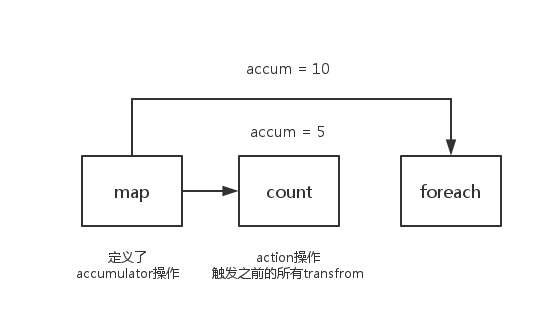

### 透過 Cache 來打斷連結
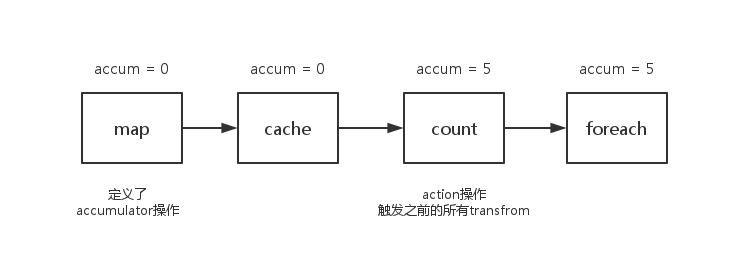

In [70]:
counter = sc.accumulator(0)
rdd = sc.parallelize(range(100))

In [71]:
rdd_count = rdd.map(lambda x: conditional_counter(x))
rdd_count.persist()

PythonRDD[26] at RDD at PythonRDD.scala:48

In [72]:
rdd_count.count()
counter.value

50

In [73]:
rdd_count.count()
counter.value

50

In [75]:
rdd_count.count()
counter.value

50

### 用累加器改寫基本功能

### count()

In [80]:
rdd.count()

100

In [81]:
count_accu = sc.accumulator(0)

In [82]:
rdd.foreach(lambda x: count_accu.add(1))
count_accu.value

100

### sum

In [86]:
rdd.reduce(lambda x, y: x + y)

4950

In [84]:
sum_accu = sc.accumulator(0)

In [85]:
rdd.foreach(lambda x: sum_accu.add(x))
sum_accu.value

4950

### Matrix Product

In [96]:
rdd1 = sc.parallelize([1,2,3,4])
rdd2 = sc.parallelize([2,4,6,8])

### dot(rdd1, rdd2) = 1*2 + 2*4 + 3*6 + 4*8  = 60

In [98]:
prod_accu = sc.accumulator(0)

In [99]:
rdd1.zip(rdd2).foreach(lambda (x,y): prod_accu.add(x * y))

In [100]:
prod_accu.value

60